# Практическое задание по теме 4. Временные ряды
## Построение и оценка моделей

In [1]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_in_business/Lesson_3/'

### Задание 1.
Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [4]:
file_name = 'my_PJME_MW.csv'
data = pd.read_csv(PATH + file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(145374, 13)


,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [5]:
TARGET_NAME = 'PJME_MW'

In [6]:
def plot_target(data, title_str, stat=True):
    if stat:
        DF_ct = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ct')
        DF_ctt = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ctt')
        print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}') 
        
    (title, name_1) = title_str
    plt.figure(figsize =(20, 4))
    plt.plot( data.index, data[TARGET_NAME], 'b' )
    plt.title(title, size=14)
    plt.xlabel('Время')
    plt.ylabel(name_1)
    plt.show()

Augmented Dickey–Fuller тест: 0.0, 0.0


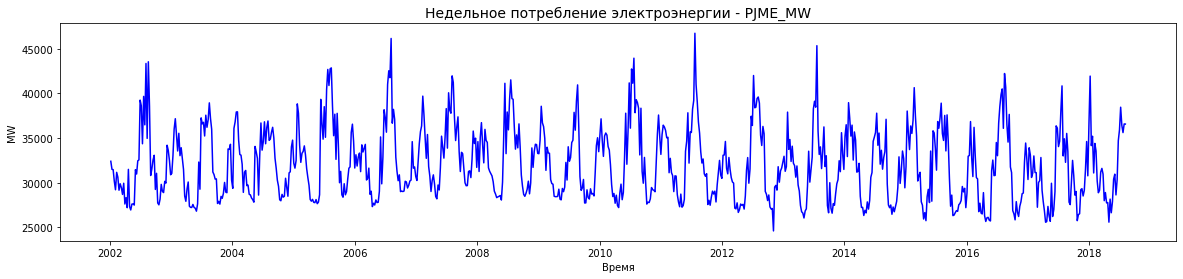

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.0,0.167832
2002-01-13,31487.386905,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.0,0.000000


In [7]:
data_w = data.resample('W').mean()
title_str = 'Недельное потребление электроэнергии - PJME_MW', 'MW'
plot_target(data_w, title_str)
data_w.head(2)

#### Отбор релевантных признаков.

In [8]:
data_w = data_w[[TARGET_NAME, 'year', 'quarter', 'weekofyear']]
data_w.head(2)

,PJME_MW,year,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.0,2.0


### Задание 2.
Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

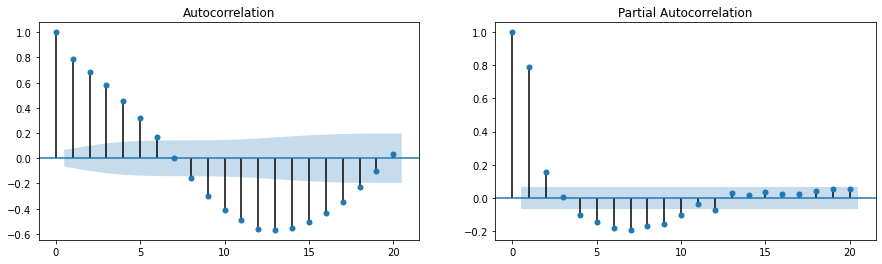

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 20

sm.graphics.tsa.plot_acf(data_w[TARGET_NAME].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_w[TARGET_NAME].values, lags=lag, ax=axes[1])
plt.show()

#### Генерация новых признаков
AR - Авторегрессионная модель, с параметром р - глубина регрессии. В качестве признаков будем использовать измерения, которые делали в р предшествующие моменты времени.

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]]           # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return np.array(result)

In [11]:
def feature_engineering(data, exp_smoothing_coef, p=3):
    df = pd.DataFrame(data[TARGET_NAME], columns=[TARGET_NAME])
    # AR
    for i in range(1, p + 1):
        col_name = 't' + str(i)
        df.loc[i:, col_name] = df[TARGET_NAME][:-i].values
        
    # exponential smoothing
    for k in exp_smoothing_coef:
        col_name = 'exp_' + str(k)
        df.loc[:, col_name] = exponential_smoothing(df[TARGET_NAME], k)
        
    # diff 1st order
    df.loc[1:, 'diff_1'] = df[TARGET_NAME][:-1].values - df[TARGET_NAME][1:].values
    
    # diff 2nd order
    df.loc[1:, 'diff_2'] = df['diff_1'][:-1].values - df['diff_1'][1:].values
    
    data_new = pd.concat([data, df.loc[:, 't1':]], axis=1)
    
    return data_new.fillna(0)

In [12]:
exp_smoothing_coef = [0.05, 0.15, 0.25]
data_w = feature_engineering(data_w, exp_smoothing_coef, 13)
data_w.head(2)

,PJME_MW,year,quarter,weekofyear,t1,t2,t3,t4,t5,t6,...,t9,t10,t11,t12,t13,exp_0.05,exp_0.15,exp_0.25,diff_1,diff_2
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32392.160839,32392.160839,32392.160839,0.000000,0.0
2002-01-13,31487.386905,2002.0,1.0,2.0,32392.160839,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32346.922142,32256.444749,32165.967356,904.773934,0.0


In [13]:
INEPENDENT_VARIABLE_NAMES = data_w.columns[1:]

#### Разделение данных на обучающую и тестовую выборку

In [14]:
def train_test_split(data, split_date, h=1):
    train = data[data.index.get_level_values('Date') < split_date]
    test = data[data.index.get_level_values('Date') >= split_date]

    X_train = train.iloc[:-h,:]    
    X_test = test.iloc[:-h,:]
    
    return X_train, X_test

In [15]:
split_date = '2016-08-02'
h = 4
df_train, df_test = train_test_split(data_w, split_date, h)

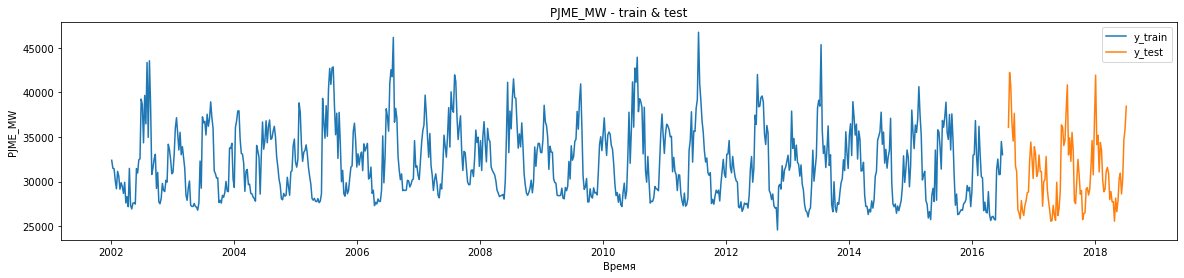

In [16]:
plt.figure( figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel(TARGET_NAME)
plt.plot(df_train.index, df_train[TARGET_NAME], label='y_train' )
plt.plot(df_test.index, df_test[TARGET_NAME], label='y_test')
plt.title(f'{TARGET_NAME} - train & test' )
plt.legend()
plt.show()

#### Отбор признаков

In [17]:
def select_variables(X, y, k_best=5, percentile=10):
    cols = X.columns
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    y = scaler.fit_transform(np.array(y).reshape(-1, 1))       
    
    f_test, _ = f_regression(X, y)
    f_test /= np.max(f_test)

    # KBest
    sfk = SelectKBest(f_regression, k=k_best)
    sfk.fit_transform(X, y)    
    set_1 = list(cols[sfk.get_support()])

    # Percentile
    sfp = SelectPercentile(f_regression, percentile=percentile)
    sfp.fit_transform(X, y)    
    set_2 = list(cols[sfp.get_support()])

    # Model
    model_gb = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)
    model_gb.fit(X, y.ravel())

    sfm = SelectFromModel(model_gb,  max_features=k_best)
    sfm.fit(X, y.ravel())
    sfm.transform(X)    
    set_3 = list(cols[sfm.get_support()])

    
    return list(set(set_1 + set_2 + set_3))

In [18]:
SELECTED_VARIABLE_NAMES = select_variables(df_train[INEPENDENT_VARIABLE_NAMES], df_train[TARGET_NAME])
SELECTED_VARIABLE_NAMES

['t2', 'exp_0.25', 'diff_1', 't1', 't3', 'exp_0.15']

#### Mодель

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
def plot_predictions(y, y_pred):
    plt.figure( figsize=(15, 4))

    plt.xlabel('Время')
    plt.ylabel('МВт')
    plt.plot(df_test.index, y_pred, label='прогноз' )
    plt.plot(df_test.index, y, label='факт')
    plt.title('Потребление энергии, МВт')

    plt.legend()
    plt.show()

In [21]:
def plot_corr_with_lag(y, y_pred, lag=5):
    corr_list = [np.corrcoef(y, y_pred)[1,0]]

    for i in range(lag):
        corr = np.corrcoef(y[:-(i+1)], y_pred[(i+1):])[1,0]
        corr_list.append(corr)    

    plt.figure(figsize=(8, 4))
    plt.plot(corr_list)
    plt.xlabel('Лаг корреляции')
    plt.ylabel('Коэффициенты корреляции')
    plt.title('Корреляция цели и предсказаний с лагом просмотра', size=14)
    plt.show()

mse:	157945.93
mae:	272.321
R2:	0.99
mape:	0.892%


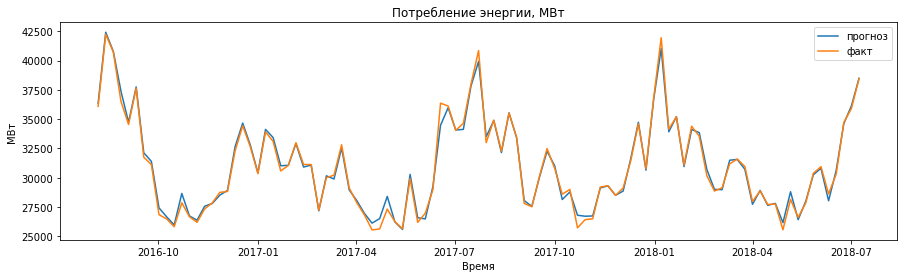

In [22]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(df_train[SELECTED_VARIABLE_NAMES], df_train[TARGET_NAME])

y_pred = model_gb.predict(df_test[SELECTED_VARIABLE_NAMES])

y = df_test[TARGET_NAME]
mse = mean_squared_error(y, y_pred) 
mae = mean_absolute_error(y, y_pred) 
R2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'mse:\t{round(mse, 3)}\nmae:\t{round(mae, 3)}\nR2:\t{round(R2, 3)}\nmape:\t{round(mape, 3)}%')

plot_predictions(y, y_pred)

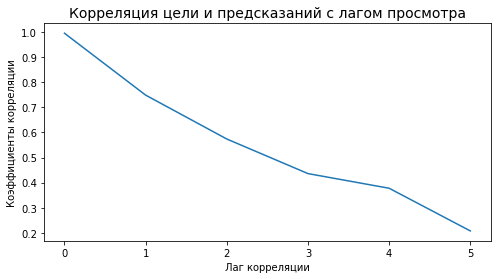

In [23]:
y = df_test[TARGET_NAME].values
plot_corr_with_lag(y, y_pred)

In [24]:
y_pred_gb_4 = y_pred

### Задание 3.
Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [25]:
h = 1
df_train, df_test = train_test_split(data_w, split_date, h)

mse:	149774.171
mae:	272.112
R2:	0.99
mape:	0.886%


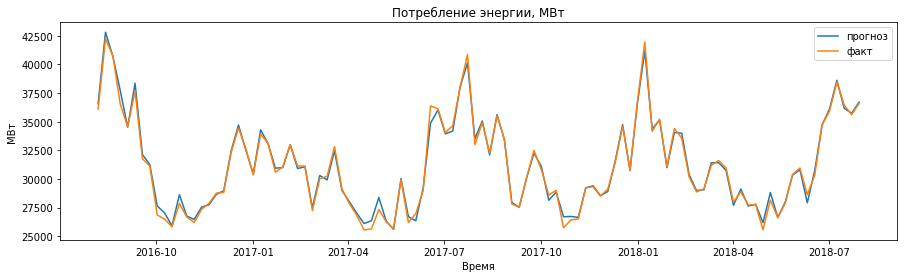

In [26]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(df_train[SELECTED_VARIABLE_NAMES], df_train[TARGET_NAME])

y_pred = model_gb.predict(df_test[SELECTED_VARIABLE_NAMES])

y = df_test[TARGET_NAME]
mse = mean_squared_error(y, y_pred) 
mae = mean_absolute_error(y, y_pred) 
R2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'mse:\t{round(mse, 3)}\nmae:\t{round(mae, 3)}\nR2:\t{round(R2, 3)}\nmape:\t{round(mape, 3)}%')

plot_predictions(y, y_pred)

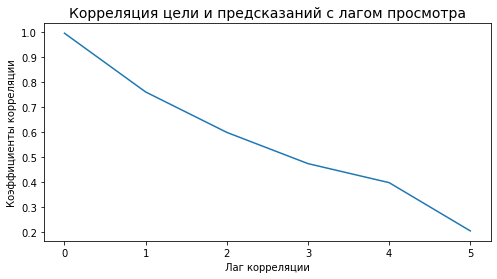

In [27]:
y = df_test[TARGET_NAME].values
plot_corr_with_lag(y, y_pred)

In [28]:
y_pred_gb_1 = y_pred

### Задание 4.
Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [29]:
def recalculate_X_test(df, i):
    if i == 0:
        df.loc[ind[i], SELECTED_VARIABLE_NAMES] = df_test.loc[ind[i], SELECTED_VARIABLE_NAMES]

    else:
        df.loc[ind[i], 't1'] = df.loc[ind[i - 1], TARGET_NAME]        
        df.loc[ind[i], 'diff_1'] = df.loc[ind[i - 1], TARGET_NAME] - df.loc[ind[i - 1], 't1']

        for alpha in [0.15, 0.25]:
            value = alpha * df.loc[ind[i-1], TARGET_NAME] + (1 - alpha) * df.loc[ind[i - 1], 't1']
            df.loc[ind[i], f'exp_{alpha}'] = value

        if i == 1:
            df.loc[ind[i], 't2'] = df_test.loc[ind[i], 't2']
            df.loc[ind[i], 't3'] = df_test.loc[ind[i], 't3']

        elif i == 2:
            df.loc[ind[i], 't2'] = df.loc[ind[i - 2], TARGET_NAME]
            df.loc[ind[i], 't3'] = df_test.loc[ind[i], 't3']

        else:
            df.loc[ind[i], 't2'] = df.loc[ind[i - 2], TARGET_NAME]
            df.loc[ind[i], 't3'] = df.loc[ind[i - 3], TARGET_NAME]
            
    return df

In [30]:
def recalculate_df_test(ind):    
    cols = [TARGET_NAME] + SELECTED_VARIABLE_NAMES
    df_test_rolling = pd.DataFrame(index=ind, columns=cols)

    for i, index in enumerate(ind):
        df_test_rolling = recalculate_X_test(df_test_rolling, i)

        y_pred = model_gb.predict(pd.DataFrame(df_test_rolling.loc[index, SELECTED_VARIABLE_NAMES]).T)[0]
        df_test_rolling.loc[index, TARGET_NAME] = y_pred
        
    return df_test_rolling

In [31]:
predictions_horizon = 4
ind = df_test.index[: predictions_horizon]
df_test_rolling = recalculate_df_test(ind)
df_test_rolling

,PJME_MW,t2,exp_0.25,diff_1,t1,t3,exp_0.15
Date,,,,,,,
2016-08-07,36565.8,39871.3,36651.4,4423.44,40514.8,38555.8,34815.1
2016-08-14,41986.4,40514.8,39527.6,-3948.96,36565.8,39871.3,39922.5
2016-08-21,38208.8,36565.8,37921,5420.58,41986.4,40514.8,37378.9
2016-08-28,43249.1,41986.4,41042,-3777.6,38208.8,36565.8,41419.8


mape direct prediction:	 2.39%
mape slide prediction:	 18.43%


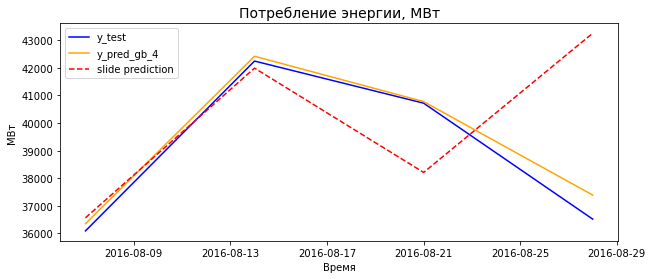

In [32]:
t = predictions_horizon - 1
actual = df_test.loc[ind[t], TARGET_NAME]
forecast = df_test_rolling.loc[ind[t], TARGET_NAME]

mape_1 = mean_absolute_percentage_error(actual, y_pred_gb_4[t])
mape_2 = mean_absolute_percentage_error(actual, forecast)
print(f'mape direct prediction:\t {round(mape_1, 2)}%\nmape slide prediction:\t {round(mape_2, 2)}%')

plt.figure( figsize=(10, 4))

plt.plot(df_test.loc[ind, TARGET_NAME], 'b', label='y_test')
plt.plot(ind, y_pred_gb_4[: len(ind)], 'orange', label='y_pred_gb_4')
plt.plot(df_test_rolling.loc[ind, TARGET_NAME], '--r', label='slide prediction')

plt.xlabel('Время')
plt.ylabel('МВт')
plt.title('Потребление энергии, МВт', size=14)
plt.legend()
plt.show() 

### Задание 5.
Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

In [33]:
n_samples = 20
name = 'step_'
cols = [name + str(i+1) for i in range(predictions_horizon)] 
results = pd.DataFrame(index=range(n_samples), columns=cols)

starting_points = random.sample(range(len(y_pred_gb_4) - predictions_horizon), n_samples)

for i, t in enumerate(starting_points):
    ind = df_test.index[t : t + predictions_horizon]
    df_test_rolling = recalculate_df_test(ind)
    
    for j in range(predictions_horizon):
        value = (df_test.loc[ind[j], TARGET_NAME] - df_test_rolling.loc[ind[j], TARGET_NAME]) /\
                 df_test.loc[ind[j], TARGET_NAME]        
        results.loc[i, f'{name}{j+1}'] = abs(value) * 100

results.loc['mape'] = results.mean()
results

,step_1,step_2,step_3,step_4
0,0.415918,3.19758,7.15049,4.78956
1,4.10597,19.642,7.56533,13.709
2,0.989471,7.70094,12.1567,6.50482
3,0.723657,6.02799,12.9056,9.43551
4,0.746064,1.93508,13.119,4.17777
5,0.320446,7.31401,5.65519,3.53711
6,0.990829,3.85765,6.01223,9.17393
7,0.198763,10.8474,6.82084,9.97717
8,0.0745507,10.7706,6.22805,3.2062
9,0.573767,18.1948,11.7343,21.8164


### Задание 6.
Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Средняя ошибка прогнозирования рекурсивной модели растет с 1% на первом шаге до 9% на последующих.